<a href="https://colab.research.google.com/github/chiangtinhung-rgb/Matcha/blob/main/HW3_%E5%BE%85%E8%BE%A6%E6%B8%85%E5%96%AE%E8%88%87%E7%95%AA%E8%8C%84%E9%90%98%E7%B4%80%E9%8C%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW3-待辦清單與番茄鐘時間管理系統


### 🎯 目標
本專案旨在建立一個結合待辦事項管理、時間追蹤（番茄鐘紀錄）與人工智慧排程建議的**一體化生產力工具**。核心目標是透過數據化管理與智慧排程，幫助使用者提高任務完成效率與時間預估準確度。

### 💡 核心功能與數據持久化

#### 1. 任務與數據管理
* **數據核心：** 所有待辦任務（To-do）和番茄鐘紀錄（Logs）資料皆透過 **Google Sheets** 維護，確保數據的持久性、可追溯性與跨平台同步性。
* **關鍵追蹤欄位：**
    * **狀態 (`status`)：** 追蹤任務進度（待辦、進行中、已完成）。
    * **預估時間 (`est_min`)：** 記錄任務開始前的時間預估，用於數據分析。
    * **實際完成時間 (`actual_min`)：** 記錄實際花費的時間，用於計算時間準確度。
* **操作流程：** 允許使用者透過 **Gradio 介面**執行新增、標記完成、刪除任務/紀錄等操作，並自動將所有更新寫回 Google Sheets。

#### 2. 每日進度輸出與追蹤
* **即時計畫呈現：** 系統能輸出當日的**待辦清單**和**總體計畫**，讓使用者一目瞭然。
* **完成率分析：** 系統將即時計算並輸出**任務完成率**（今日已完成任務數 / 總任務數），提供每日效率概覽。
* **完成標記回寫：** 當任務在系統中被標記完成後，程式會同步將完成標記寫回 Google Sheet 數據源。

### ✨ 人工智慧 (AI) 創新整合：智慧排程

#### 3. 三段式行動計畫建議 (AI 點子)
* **智慧排程核心：** 整合大型語言模型 (LLM)，實現創新的**三段式行動計畫**建議。
* **功能描述：** 模型將分析使用者當日所有待辦任務，根據任務的優先度、預估時長、和性質，將任務智慧劃分為三個建議的行動區塊：
    * **Morning Plan (上午計畫)：** 建議在上午時段完成的任務。
    * **Afternoon Plan (下午計畫)：** 建議在下午時段完成的任務。
    * **Evening Plan (晚間計畫)：** 建議在傍晚或晚上完成的任務。
* **價值：** 將傳統的靜態待辦清單轉化為結構化的**每日行動指南**，幫助使用者優化時間分配，減少排程決策負擔，提高執行流暢性。



# 刪除任務與清除紀錄(刪除/清除完要按刷新紀錄確保清除)


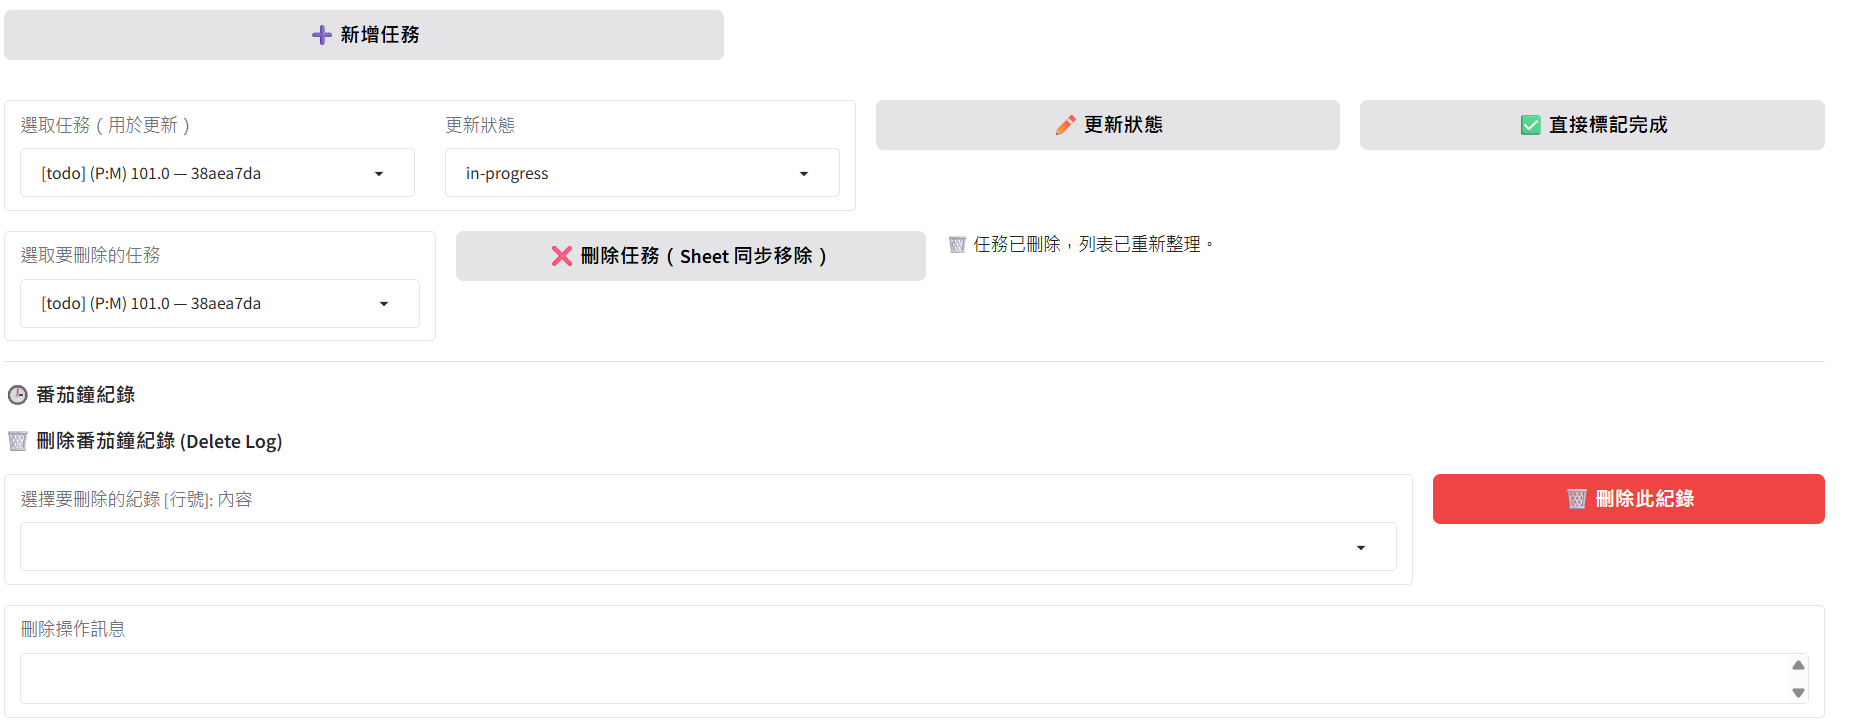

# 匯出與匯入檔案
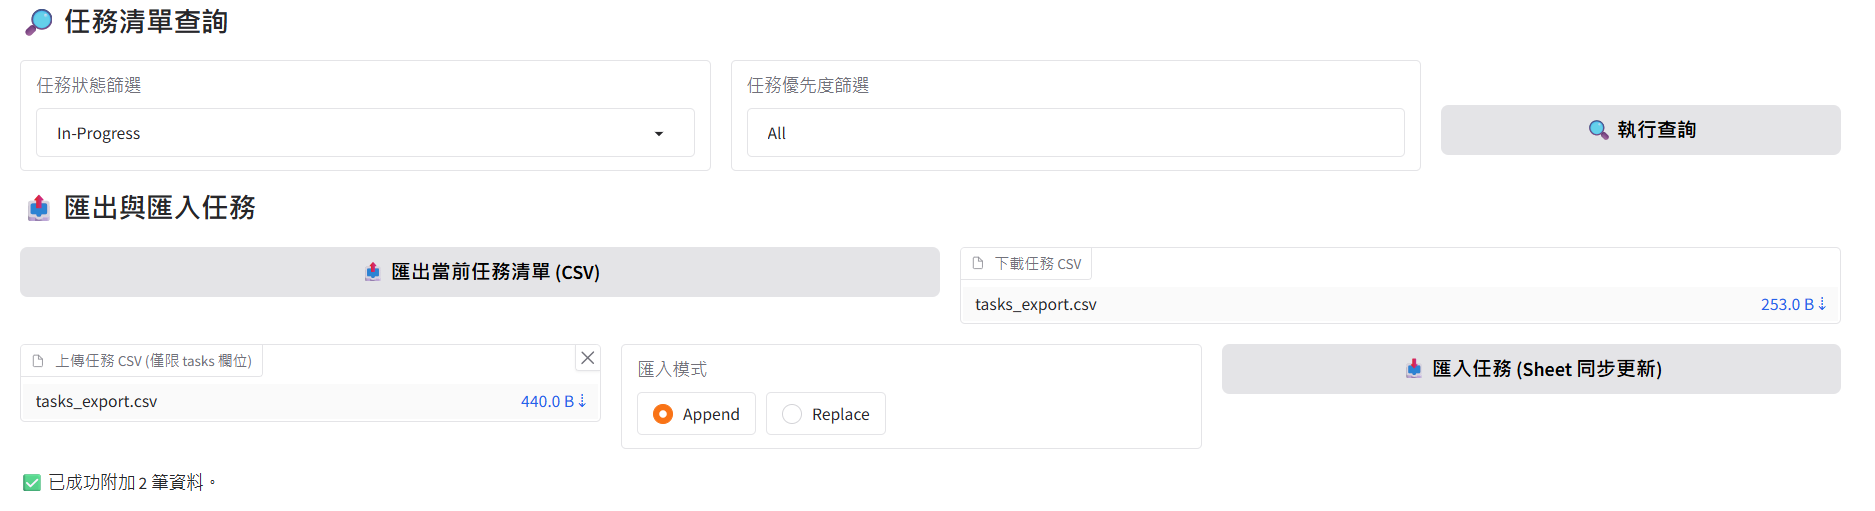

In [110]:
!pip -q install gspread gspread_dataframe google-auth google-auth-oauthlib google-auth-httplib2 \
               gradio pandas beautifulsoup4 google-generativeai python-dateutil

In [111]:
import os, time, uuid, re, json, datetime
from datetime import datetime as dt, timedelta
from dateutil.tz import gettz
import pandas as pd
import gradio as gr
import requests
from bs4 import BeautifulSoup

import google.generativeai as genai

# Google Auth & Sheets
from google.colab import auth
import gspread
from gspread_dataframe import set_with_dataframe, get_as_dataframe
from google.auth.transport.requests import Request
from google.oauth2 import service_account
from google.auth import default

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
import io # 用於將 Matplotlib 圖表轉換為 Gradio 支援的格式

In [113]:
def load_data_from_sheet():
    """從 Google Sheet 載入資料並轉換為 DataFrame，增加 'Sheet_Row_Index' 輔助欄位。"""
    try:
        # 假設 gsheets, gc, SHEET_URL, WORKSHEET_NAME 已在前面定義並授權成功
        sh = gc.open_by_url(SHEET_URL).worksheet(WORKSHEET_NAME)
        data = sh.get_all_values()

        # 檢查資料是否包含標題行
        if len(data) < 1:
            return pd.DataFrame(), sh

        df = pd.DataFrame(data[1:], columns=data[0])

        # 嘗試將 '完成時間' 轉換為 datetime 物件
        if '完成時間' in df.columns:
            # 確保 '完成時間' 格式正確，錯誤值將設為 NaT
            df['完成時間'] = pd.to_datetime(df['完成時間'], errors='coerce', dayfirst=False)

        # 新增試算表行號 (1-based)，用於後續的刪除任務功能
        # DataFrame 的 index 0 對應試算表的 Row 2 (Row 1 是標題)
        df['Sheet_Row_Index'] = df.index + 2

        return df, sh
    except Exception as e:
        print(f"載入 Google Sheet 失敗: {e}")
        return pd.DataFrame(), None

# 執行初始載入（可替換您原有的載入程式碼）
df, sh = load_data_from_sheet()
if sh is None:
    print("無法連接或讀取 Google Sheet，請檢查設定。")
else:
    print(f"成功載入 {len(df)} 筆資料，用於 Gradio 介面。")

# 為了在 Gradio 中直接下載檔案，需要這個 Colab 內建工具
from google.colab import files

成功載入 0 筆資料，用於 Gradio 介面。


In [114]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [115]:
from google.colab import userdata

# 從 Colab Secrets 中獲取 API 金鑰
api_key = userdata.get('MATCHA')

# 使用獲取的金鑰配置 genai
genai.configure(api_key=api_key)

model = genai.GenerativeModel('gemini-2.5-pro')

In [116]:
SHEET_URL = "https://docs.google.com/spreadsheets/d/18dkFbMgVdFi9I42bCs_rbXYfw_akhw_ntSziJzYkVXQ/edit?usp=sharing"
WORKSHEET_NAME = "工作表1"
TIMEZONE = "Asia/Taipei"

In [117]:
import pandas as pd
# read data and put it in a dataframe
# 在 google 工作表載入 gsheets
gsheets = gc.open_by_url(SHEET_URL)


# 從 gsheets 的 All-whiteboard-device 載入 sheets
sh = gsheets.worksheet(WORKSHEET_NAME).get_all_values()
# 將 sheets1 資料載入 pd 的 DataFrame 進行分析
df = pd.DataFrame(sh[1:], columns=sh[0])
# 取得最前面的5筆資料
df.head()

""


In [119]:
def ensure_spreadsheet(name):
    try:
        sh = gc.open(name)  # returns gspread.models.Spreadsheet
    except gspread.SpreadsheetNotFound:
        sh = gc.create(name)
    return sh

sh = ensure_spreadsheet(WORKSHEET_NAME)

In [120]:
def ensure_worksheet(sh, title, header):
    try:
        ws = sh.worksheet(title)
    except gspread.WorksheetNotFound:
        ws = sh.add_worksheet(title=title, rows="1000", cols=str(len(header)+5))
        ws.update([header])
    # 若沒有表頭就補上
    data = ws.get_all_values()
    if not data or (data and data[0] != header):
        ws.clear()
        ws.update([header])
    return ws

TASKS_HEADER = [
    "id","task","status","priority","est_min","start_time","end_time",
    "actual_min","pomodoros","due_date","labels","notes",
    "created_at","updated_at","completed_at","planned_for"
]
LOGS_HEADER = [
    "log_id","task_id","phase","start_ts","end_ts","minutes","cycles","note"
]
CLIPS_HEADER = ["clip_id","url","selector","text","href","created_at","added_to_task"]

ws_tasks = ensure_worksheet(sh, "tasks", TASKS_HEADER)
ws_logs  = ensure_worksheet(sh, "pomodoro_logs", LOGS_HEADER)
ws_clips = ensure_worksheet(sh, "web_clips", CLIPS_HEADER)

def tznow():
    return dt.now(gettz(TIMEZONE))

def read_df(ws, header):
    df = get_as_dataframe(ws, evaluate_formulas=True, header=0)
    if df is None or df.empty:
        return pd.DataFrame(columns=header)
    df = df.fillna("")
    # 保證欄位齊全
    for c in header:
        if c not in df.columns:
            df[c] = ""
    # 型別微調
    if "est_min" in df.columns:
        df["est_min"] = pd.to_numeric(df["est_min"], errors="coerce").fillna(0).astype(int)
    if "actual_min" in df.columns:
        df["actual_min"] = pd.to_numeric(df["actual_min"], errors="coerce").fillna(0).astype(int)
    if "pomodoros" in df.columns:
        df["pomodoros"] = pd.to_numeric(df["pomodoros"], errors="coerce").fillna(0).astype(int)
    return df[header]

def write_df(ws, df, header):
    if df.empty:
        ws.clear()
        ws.update([header])
        return
    # 轉字串避免 gspread 型別問題
    df_out = df.copy()
    for c in df_out.columns:
        df_out[c] = df_out[c].astype(str)
    ws.clear()
    ws.update([header] + df_out.values.tolist())

def refresh_all():
    return (
        read_df(ws_tasks, TASKS_HEADER).copy(),
        read_df(ws_logs, LOGS_HEADER).copy(),
        read_df(ws_clips, CLIPS_HEADER).copy()
    )

tasks_df, logs_df, clips_df = refresh_all()

def add_task(task, priority, est_min, due_date, labels, notes, planned_for):
    global tasks_df
    _now = tznow().isoformat()
    new = pd.DataFrame([{
        "id": str(uuid.uuid4())[:8],
        "task": task.strip(),
        "status": "todo",
        "priority": priority or "M",
        "est_min": int(est_min) if est_min else 25,
        "start_time": "",
        "end_time": "",
        "actual_min": 0,
        "pomodoros": 0,
        "due_date": due_date or "",
        "labels": labels or "",
        "notes": notes or "",
        "created_at": _now,
        "updated_at": _now,
        "completed_at": "",
        "planned_for": planned_for or ""  # 可填 today / tomorrow / 空白
    }])
    tasks_df = pd.concat([tasks_df, new], ignore_index=True)
    write_df(ws_tasks, tasks_df, TASKS_HEADER)
    return "✅ 已新增任務", tasks_df

def update_task_status(task_id, new_status):
    global tasks_df
    idx = tasks_df.index[tasks_df["id"] == task_id]
    if len(idx)==0:
        return "⚠️ 找不到任務", tasks_df
    i = idx[0]
    tasks_df.loc[i, "status"] = new_status
    tasks_df.loc[i, "updated_at"] = tznow().isoformat()
    if new_status == "done" and not tasks_df.loc[i, "completed_at"]:
        tasks_df.loc[i, "completed_at"] = tznow().isoformat()
    write_df(ws_tasks, tasks_df, TASKS_HEADER)
    return "✅ 狀態已更新", tasks_df

def mark_done(task_id):
    return update_task_status(task_id, "done")

def recalc_task_actuals(task_id):
    """根據 logs_df 回寫 actual_min 與 pomodoros"""
    global tasks_df, logs_df
    work_logs = logs_df[(logs_df["task_id"]==task_id) & (logs_df["phase"]=="work")]
    total_min = work_logs["minutes"].astype(float).sum() if not work_logs.empty else 0
    pomos = int(round(total_min / 25.0))
    idx = tasks_df.index[tasks_df["id"]==task_id]
    if len(idx)==0: return
    i = idx[0]
    tasks_df.loc[i,"actual_min"] = int(total_min)
    tasks_df.loc[i,"pomodoros"] = pomos
    tasks_df.loc[i,"updated_at"] = tznow().isoformat()

def list_task_choices():
    global tasks_df
    if tasks_df.empty:
        return []
    # 顯示： [status] (P:priority) task  — id
    def row_label(r):
        return f"[{r['status']}] (P:{r['priority']}) {r['task']} — {r['id']}"
    return [(row_label(r), r["id"]) for _, r in tasks_df.iterrows()]

# 我們採「按鈕開始 / 結束」模式（避免後端阻塞），每次按「開始」會先記住 start_ts，
# 按「結束」時計算分鐘並寫入 logs，再回填任務 actual_min / pomodoros。

_active_sessions = {}  # { task_id: {"phase": "work"/"break", "start_ts": iso, "cycles": int} }

def start_phase(task_id, phase, cycles):
    if not task_id: return "⚠️ 請先選擇任務"
    _active_sessions[task_id] = {
        "phase": phase,
        "start_ts": tznow().isoformat(),
        "cycles": int(cycles) if cycles else 1
    }
    return f"▶️ 已開始：{phase}（task: {task_id}）"

def end_phase(task_id, note):
    global logs_df, tasks_df
    if task_id not in _active_sessions:
        return "⚠️ 尚未開始任何階段"
    sess = _active_sessions.pop(task_id)
    start = pd.to_datetime(sess["start_ts"])
    end = tznow()
    minutes = round((end - start).total_seconds() / 60.0, 2)
    log = pd.DataFrame([{
        "log_id": str(uuid.uuid4())[:8],
        "task_id": task_id,
        "phase": sess["phase"],
        "start_ts": start.isoformat(),
        "end_ts": end.isoformat(),
        "minutes": minutes,
        "cycles": int(sess["cycles"]),
        "note": note or ""
    }])
    logs_df = pd.concat([logs_df, log], ignore_index=True)
    write_df(ws_logs, logs_df, LOGS_HEADER)

    # 回填任務
    if sess["phase"] == "work":
        recalc_task_actuals(task_id)
        write_df(ws_tasks, tasks_df, TASKS_HEADER)

    return f"⏹️ 已結束：{sess['phase']}，紀錄 {minutes} 分鐘"


In [137]:
# --- 請新增此函數 ---
def load_tasks_df_with_index():
    """載入 tasks 工作表資料，並計算並新增 'Sheet_Row_Index' 欄位。"""

    # 1. 使用現有的 read_df 函數載入任務資料 (它會載入 TASKS_HEADER 內定義的欄位)
    df = read_df(ws_tasks, TASKS_HEADER)

    if df.empty:
        # 處理空 DataFrame 的情況
        df['Sheet_Row_Index'] = pd.Series([], dtype='int')
        return df.copy()

    # 2. 確保 DataFrame 索引是從 0 開始的連續索引
    df = df.reset_index(drop=True)

    # 3. 重新計算並新增試算表行號 (1-based)
    # DataFrame 的 index 0 對應試算表的 Row 2 (Row 1 是標題)
    df['Sheet_Row_Index'] = df.index + 2

    return df.copy()

# --- 請修改您的 refresh_all 函數 ---
def refresh_all():
    global tasks_df, logs_df, clips_df

    # 任務列表改用新的載入函數，確保有 Sheet_Row_Index
    tasks_df = load_tasks_df_with_index()
    logs_df = read_df(ws_logs, LOGS_HEADER).copy()
    clips_df = read_df(ws_clips, CLIPS_HEADER).copy()

    return tasks_df, logs_df, clips_df

# 執行初始化：請確保您的 Colab 筆記本有執行這行
tasks_df, logs_df, clips_df = refresh_all()

In [139]:
def delete_task(task_id):
    """根據 task_id 刪除任務，並從 Google Sheet 中移除對應行。"""
    global tasks_df, ws_tasks

    # 1. 找到任務
    idx = tasks_df.index[tasks_df["id"] == task_id]
    if len(idx) == 0:
        return "⚠️ 找不到任務，請確認 ID 是否正確", tasks_df

    try:
        # 2. 取得要刪除的任務在 Sheet 中的行號 (依賴步驟一確保此欄位存在且正確)
        row_to_delete = tasks_df.loc[idx[0], 'Sheet_Row_Index']
    except KeyError:
        return "⚠️ 刪除失敗：tasks_df 缺少 'Sheet_Row_Index' 欄位。請檢查步驟一是否正確執行。", tasks_df

    # 3. 從 DataFrame 中移除 (這是本地操作，之後會被刷新覆蓋)
    # 這裡先移除只是為了確保在 gspread 刪除失敗時，本地仍能返回更新後的 df
    tasks_df = tasks_df.drop(idx).reset_index(drop=True)

    try:
        # 4. 從 Google Sheet 中移除對應行
        # Row 1 是標題，所以 row_to_delete (從 2 開始) 是正確的。
        ws_tasks.delete_rows(int(row_to_delete))

        # 5. 關鍵修正：強制重新載入所有資料 (更新所有任務的 Sheet_Row_Index)
        tasks_df, _, _ = refresh_all()

        return "🗑️ 任務已刪除，列表已重新整理。", tasks_df

    except Exception as e:
        # 如果刪除 Google Sheet 行失敗，重新載入任務列表以保持同步
        print(f"刪除 Google Sheet 行失敗: {e}")
        tasks_df, _, _ = refresh_all()
        return f"⚠️ Google Sheet 行刪除失敗，請手動確認。錯誤: {e}", tasks_df



In [123]:
import pandas as pd
from datetime import datetime
# 假設您已經定義了 load_logs_df_with_index() 和 refresh_all() 函數
# 並且 ws_logs 是 Google Sheets 中番茄鐘紀錄的工作表物件

def load_logs_df_with_index():
    """載入 logs_df，並加入 Sheet_Row_Index 欄位。"""
    # 這裡應該是您實際讀取 Google Sheet 'logs' 工作表的程式碼
    # 為確保程式碼完整，假設這會返回一個包含 'Sheet_Row_Index' 的 DataFrame
    global ws_logs
    if ws_logs is None:
        return pd.DataFrame()

    # 這裡應使用 gspread 讀取 logs 工作表並計算行號
    data = ws_logs.get_all_values()
    if not data:
        return pd.DataFrame(columns=['id', 'task', 'duration', 'completed_at', 'Sheet_Row_Index'])

    headers = data[0]
    df = pd.DataFrame(data[1:], columns=headers)

    # 為每一行添加其在 Google Sheet 中的實際行號 (從 2 開始，因為第 1 行是標題)
    df['Sheet_Row_Index'] = range(2, len(df) + 2)

    return df

def list_log_choices():
    """為 Dropdown 產生番茄鐘紀錄的選項清單 (ID: 內容)"""
    full_logs_df = load_logs_df_with_index()
    if full_logs_df.empty:
        return []

    # 為了刪除，我們需要一個獨特的識別碼。
    # 這裡使用 Sheet_Row_Index 作為識別碼的前綴。
    def format_log_choice(r):
        # 顯示格式: [行號]: [持續時間] min, 任務 [任務ID] - [完成時間]
        return f"{r['Sheet_Row_Index']}: {r['duration']} min, 任務 {r['task']} - {r['completed_at']}"

    # 返回 Sheet_Row_Index 和格式化後的字串，方便使用者選擇和程式追蹤行號
    return full_logs_df.apply(format_log_choice, axis=1).tolist()


def delete_log(log_row_index_with_info):
    """根據 Sheet_Row_Index 刪除番茄鐘紀錄，並從 Google Sheet 中移除對應行。"""
    global logs_df, ws_logs

    if not log_row_index_with_info:
        # 返回當前的 logs_df (不包含 Sheet_Row_Index)
        return "⚠️ 請選擇一筆番茄鐘紀錄。", logs_df.drop(columns=['Sheet_Row_Index'], errors='ignore')

    try:
        # 從字串中提取 Sheet_Row_Index (例如 "5: 25 min, ..." -> 5)
        row_to_delete = int(log_row_index_with_info.split(":")[0].strip())
    except ValueError:
        return "⚠️ 無效的紀錄選擇。", logs_df.drop(columns=['Sheet_Row_Index'], errors='ignore')

    if row_to_delete < 2:
        return "⚠️ 錯誤：無法刪除標題行。", logs_df.drop(columns=['Sheet_Row_Index'], errors='ignore')

    try:
        # 1. 從 Google Sheet 中移除對應行
        if ws_logs:
            # row_to_delete 必須是整數
            ws_logs.delete_rows(row_to_delete)

        # 2. 強制重新載入所有資料 (更新所有紀錄的 Sheet_Row_Index)
        tasks_df_clean, logs_df_clean, clips_df_clean = refresh_all() # 假設 refresh_all 會更新全局 logs_df

        # 返回成功訊息和更新後的 logs_df (Gradio grid)
        return f"🗑️ 番茄鐘紀錄 (行號 {row_to_delete}) 已刪除，列表已重新整理。", logs_df_clean.drop(columns=['Sheet_Row_Index'], errors='ignore')

    except Exception as e:
        print(f"刪除 Google Sheet 行失敗: {e}")
        # 即使刪除失敗，也強制刷新確保數據一致
        tasks_df_clean, logs_df_clean, clips_df_clean = refresh_all()
        return f"⚠️ Google Sheet 行刪除失敗，請手動確認。錯誤: {e}", logs_df_clean.drop(columns=['Sheet_Row_Index'], errors='ignore')

In [124]:
def query_tasks(status_filter, start_date_str, end_date_str):
    """
    根據狀態和完成時間範圍篩選任務。
    日期格式為 YYYY-MM-DD。
    """
    global tasks_df
    df = tasks_df.copy()

    # 狀態篩選
    if status_filter and status_filter != "All":
        df = df[df["status"] == status_filter.lower()]

    # 日期篩選：需要轉換 'completed_at'
    if 'completed_at' in df.columns:
        # 轉換為日期時間物件
        df['completed_dt'] = pd.to_datetime(df['completed_at'], errors='coerce')

        # 僅考慮已完成的任務進行日期範圍篩選
        done_df = df[df['status'] == 'done'].copy()

        # 開始日期篩選
        if start_date_str:
            try:
                start_date = pd.to_datetime(start_date_str).normalize()
                done_df = done_df[done_df['completed_dt'].dt.normalize() >= start_date]
            except:
                return "⚠️ 開始日期格式錯誤，請使用 YYYY-MM-DD", pd.DataFrame(columns=tasks_df.columns)

        # 結束日期篩選
        if end_date_str:
            try:
                end_date = pd.to_datetime(end_date_str).normalize()
                done_df = done_df[done_df['completed_dt'].dt.normalize() <= end_date]
            except:
                return "⚠️ 結束日期格式錯誤，請使用 YYYY-MM-DD", pd.DataFrame(columns=tasks_df.columns)

        # 合併未完成的任務 (如果狀態篩選不是 'done')
        if status_filter != "done" or not (start_date_str or end_date_str):
            # 找出未完成的任務（或所有狀態的任務）
            non_done_df = df[df['status'] != 'done'].copy()

            # 如果狀態篩選是 'todo' 或 'in-progress'，則只顯示未完成的任務
            if status_filter in ["todo", "in-progress"]:
                df_filtered = non_done_df
            elif status_filter == "All":
                df_filtered = pd.concat([done_df, non_done_df]).sort_values(by='created_at', ascending=False)
            else: # status_filter == "done" (但沒有日期範圍)
                df_filtered = done_df

        else: # 狀態篩選是 'done' 且有日期範圍
            df_filtered = done_df

        # 清理暫時欄位
        df_filtered = df_filtered.drop(columns=['completed_dt'], errors='ignore')

        return f"✅ 篩選結果：共 {len(df_filtered)} 筆任務", df_filtered

    return "✅ 篩選結果：共 {len(df)} 筆任務", df

In [125]:
def export_df_to_csv(df, filename="export.csv"):
    """將 DataFrame 匯出為 CSV 檔案，並在 Colab 中提供下載連結。"""
    if df.empty:
        return "⚠️ DataFrame 為空，無法匯出。"

    # 清理非必要的欄位（例如 Sheet_Row_Index）
    df_out = df.drop(columns=['Sheet_Row_Index'], errors='ignore')

    df_out.to_csv(filename, index=False, encoding='utf-8-sig')

    # 觸發 Colab 下載
    # 這裡無法直接觸發 Gradio 下載，但可以在 Colab 環境中提供下載。
    # 為了 Gradio 介面的簡潔，我們只返回成功的訊息，假設使用者在 Colab 中運行。
    # 如果要讓 Gradio 介面直接下載，需要使用 gr.File() 作為 output，並返回檔案路徑。

    # 為了讓 Gradio 成功處理檔案下載，我們需要將輸出改為 gr.File
    # 以下為 Gradio 檔案下載的方式：
    return filename, f"✅ 任務列表已匯出為 {filename}，請點擊下方的連結下載。"

# **注意：** 匯入功能需要一個 `gr.File` 輸入組件，允許使用者上傳 CSV。
def import_tasks_from_csv(file_obj, append_or_replace):
    """從上傳的 CSV 檔案匯入任務。"""
    global tasks_df, ws_tasks

    if not file_obj:
        return "⚠️ 請上傳一個 CSV 檔案", tasks_df

    try:
        # 讀取上傳的檔案路徑
        file_path = file_obj.name
        new_df = pd.read_csv(file_path)

        # 檢查是否包含必要的欄位
        required_cols = ["id", "task", "status", "priority", "est_min"]
        if not all(col in new_df.columns for col in required_cols):
            return "⚠️ CSV 缺少必要的欄位：id, task, status, priority, est_min", tasks_df

        # 確保型別正確
        new_df["est_min"] = pd.to_numeric(new_df["est_min"], errors="coerce").fillna(0).astype(int)

        if append_or_replace == "Replace":
            # 替換模式：用新資料替換舊資料
            tasks_df = new_df.copy()
            msg = f"✅ 已成功替換任務列表，匯入 {len(tasks_df)} 筆資料。"
        else: # Append 模式
            # 附加模式：將新資料附加到現有資料之後
            # 需要處理 ID 重複的問題，可以為新任務生成新的 ID
            # 為了簡潔，這裡假設匯入的任務是全新的，ID不重複，或者只附加
            tasks_df = pd.concat([tasks_df, new_df], ignore_index=True)
            msg = f"✅ 已成功附加 {len(new_df)} 筆資料。"

        # 寫回 Google Sheet (使用您的 write_df 函數)
        write_df(ws_tasks, tasks_df, TASKS_HEADER)

        return msg, tasks_df

    except Exception as e:
        return f"⚠️ 匯入 CSV 失敗: {e}", tasks_df

In [126]:
# AI 計畫（Gemini；無金鑰則規則式）
def generate_today_plan():
    global tasks_df
    # 以「due_date 是今天」或「planned_for = today」且不是 done 的任務為計畫清單
    today = tznow().date().isoformat()
    cand = tasks_df[
        ((tasks_df["due_date"]==today) | (tasks_df["planned_for"].str.lower()=="today")) &
        (tasks_df["status"]!="done")
    ].copy()
    if cand.empty:
        return "📭 今天沒有標記的任務。請在 Tasks 分頁把任務的 due_date 設為今天或 planned_for 設為 today。"

    # 先依 priority（H>M>L）+ est_min 排序
    pr_order = {"H":0, "M":1, "L":2}
    cand["p_ord"] = cand["priority"].map(pr_order).fillna(3)
    cand = cand.sort_values(["p_ord","est_min"], ascending=[True, True])

    # 嘗試 Gemini
    api_key = os.environ.get("GEMINI_API_KEY","").strip()
    if api_key:
        genai.configure(api_key=api_key)
        sys_prompt = (
            "你是一位任務規劃助理。請把輸入的任務（含估時與優先級）排成三段：morning、afternoon、evening，"
            "並給出每段的重點、順序、每項的時間預估與備註。總時數請大致符合任務估時總和。"
            "回傳以 Markdown 條列，格式：\n"
            "### Morning\n- [任務ID] 任務名稱（預估 xx 分）— 備註\n..."
            "### Afternoon\n...\n### Evening\n...\n"
        )
        items = []
        for _, r in cand.iterrows():
            items.append({
                "id": r["id"], "task": r["task"], "est_min": int(r["est_min"]),
                "priority": r["priority"]
            })
        user_content = json.dumps({"today": today, "tasks": items}, ensure_ascii=False)
        try:
            model = genai.GenerativeModel("gemini-1.5-flash")
            resp = model.generate_content(sys_prompt + "\n\n" + user_content)
            plan_md = resp.text
        except Exception as e:
            plan_md = f"⚠️ Gemini 失敗：{e}\n\n改用規則式規劃。"
    else:
        plan_md = "🔧 未設定 GEMINI_API_KEY，使用規則式規劃。\n\n"

    # 規則式：把高優先任務平均切到上午/下午/晚上
    buckets = {"morning": [], "afternoon": [], "evening": []}
    total = len(cand)
    for i, (_, r) in enumerate(cand.iterrows()):
        if i % 3 == 0:
            buckets["morning"].append(r)
        elif i % 3 == 1:
            buckets["afternoon"].append(r)
        else:
            buckets["evening"].append(r)

    def sec_md(name, rows):
        if not rows: return f"### {name.title()}\n（無）\n"
        lines = [f"### {name.title()}"]
        for r in rows:
            lines.append(f"- [{r['id']}] {r['task']}（預估 {int(r['est_min'])} 分，P:{r['priority']}）")
        return "\n".join(lines) + "\n"

    rule_md = sec_md("morning", buckets["morning"]) + "\n" + \
              sec_md("afternoon", buckets["afternoon"]) + "\n" + \
              sec_md("evening", buckets["evening"])

    return (plan_md + "\n---\n" + rule_md).strip()


In [127]:
# 今日完成率
def today_summary():
    global tasks_df
    today = tznow().date().isoformat()
    planned = tasks_df[
        ((tasks_df["due_date"]==today) | (tasks_df["planned_for"].str.lower()=="today"))
    ]
    done = planned[planned["status"]=="done"]
    total = len(planned)
    done_n = len(done)
    rate = (done_n/total*100) if total>0 else 0
    return f"📅 今日計畫任務：{total}；✅ 完成：{done_n}；📈 完成率：{rate:.1f}%"

In [128]:
def visualize_summary():
    """繪製任務狀態分佈和時間統計圖表。"""
    global tasks_df
    df = tasks_df.copy()

    if df.empty:
        return None, None, "⚠️ 任務列表為空，無法繪製圖表。"

    # 1. 任務狀態分佈 (圓餅圖)
    status_counts = df['status'].value_counts()

    # 創建圖表
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    ax1.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
    ax1.axis('equal') # 確保圓餅圖是圓的
    ax1.set_title('任務狀態分佈')

    # 將 Matplotlib 圖表轉換為 PNG 圖片 (Gradio Image 組件的常見輸入)
    buf1 = io.BytesIO()
    fig1.savefig(buf1, format='png')
    buf1.seek(0)

    # 2. 已完成任務的預估與實際時間比較 (長條圖)
    done_df = df[df['status'] == 'done']

    if done_df.empty:
        # 如果沒有完成的任務，則返回圓餅圖和空圖表
        return buf1.getvalue(), None, "✅ 狀態分佈圖已繪製。沒有完成的任務來繪製時間比較圖。"

    # 確保數值型別
    done_df['est_min'] = pd.to_numeric(done_df['est_min'], errors='coerce').fillna(0).astype(int)
    done_df['actual_min'] = pd.to_numeric(done_df['actual_min'], errors='coerce').fillna(0).astype(int)

    # 繪製長條圖
    fig2, ax2 = plt.subplots(figsize=(10, 6))

    # 匯總數據 (如果任務太多，匯總會更清晰)
    # 這裡我們只顯示前10個任務
    plot_df = done_df.head(10)[['task', 'est_min', 'actual_min']].set_index('task')
    plot_df.plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral'])

    ax2.set_title('已完成任務的預估與實際時間比較 (前10筆)')
    ax2.set_ylabel('分鐘數')
    ax2.tick_params(axis='x', rotation=45)
    plt.tight_layout()

    buf2 = io.BytesIO()
    fig2.savefig(buf2, format='png')
    buf2.seek(0)

    return buf1.getvalue(), buf2.getvalue(), "✅ 任務統計圖表已繪製。"

In [140]:
# Gradio 介面
# =========================
def _refresh():
    global tasks_df, logs_df, clips_df
    tasks_df, logs_df, clips_df = refresh_all()
    return tasks_df, logs_df, clips_df, list_task_choices(), today_summary(), list_task_choices()

with gr.Blocks(title="待辦清單＋番茄鐘＋AI 計畫（Sheet/Gradio）") as demo:
    gr.Markdown("# ✅ 待辦清單與番茄鐘（Google Sheet＋Gradio＋AI 計畫）")
    with gr.Row():
        btn_refresh = gr.Button("🔄 重新整理（Sheet → App）")
        out_summary = gr.Markdown(today_summary())

    with gr.Tab("Tasks"):
        with gr.Row():
            with gr.Column(scale=2):
                task = gr.Textbox(label="任務名稱", placeholder="寫 HW3 報告 / 修正 SQL / …")
                priority = gr.Dropdown(["H","M","L"], value="M", label="優先級")
                est_min = gr.Number(value=25, label="預估時間（分鐘）", precision=0)
                due_date = gr.Textbox(label="到期日（YYYY-MM-DD，可空白）")
                labels = gr.Textbox(label="標籤（逗號分隔，可空白）")
                notes = gr.Textbox(label="備註（可空白）")
                planned_for = gr.Dropdown(["","today","tomorrow"], value="", label="規劃歸屬")
                btn_add = gr.Button("➕ 新增任務")
                msg_add = gr.Markdown()
            with gr.Column(scale=3):
                grid_tasks = gr.Dataframe(value=tasks_df, label="任務清單（直接從 Sheet 來）", interactive=False)

        with gr.Row():
            task_choice = gr.Dropdown(choices=list_task_choices(), label="選取任務（用於更新）")
            new_status = gr.Dropdown(["todo","in-progress","done"], value="in-progress", label="更新狀態")
            btn_update = gr.Button("✏️ 更新狀態")
            btn_done = gr.Button("✅ 直接標記完成")

        with gr.Row():
            task_delete_choice = gr.Dropdown(choices=list_task_choices(), label="選取要刪除的任務")
            btn_delete = gr.Button("❌ 刪除任務（Sheet 同步移除）")
            msg_delete = gr.Markdown()
            msg_update = gr.Markdown()

    with gr.Tab("Pomodoro"):
        with gr.Row():
            sel_task = gr.Dropdown(choices=list_task_choices(), label="選擇任務")
            cycles = gr.Number(value=1, precision=0, label="番茄數（僅作紀錄）")
        with gr.Row():
            btn_start_work = gr.Button("▶️ 開始工作")
            note_work = gr.Textbox(label="工作備註（可空白）")
            btn_end_work = gr.Button("⏹️ 結束工作並記錄")
        with gr.Row():
            btn_start_break = gr.Button("🍵 開始休息")
            note_break = gr.Textbox(label="休息備註（可空白）")
            btn_end_break = gr.Button("⏹️ 結束休息並記錄")
        msg_pomo = gr.Markdown()
        grid_logs = gr.Dataframe(value=logs_df, label="番茄鐘紀錄", interactive=False)
        with gr.Tab("Pomodoro - 番茄鐘"):

            gr.Markdown("### 🕒 番茄鐘計時器")
    # ... [番茄鐘計時器相關元件] ...

    gr.Markdown("---")
    gr.Markdown("### 🕒 番茄鐘紀錄")
    # 假設 grid_logs 已經定義

    # ！！！ 檢查這裡是否有正確縮排 ！！！
    # 確保 `gr.Markdown` 與上一個元件在同一層縮排
    gr.Markdown("### 🗑️ 刪除番茄鐘紀錄 (Delete Log)")

    with gr.Row(): # <--- 如果這是 Line 55
        # ！！！ 確保這裡的元件有縮排 ！！！
        log_delete_choice = gr.Dropdown(
            label="選擇要刪除的紀錄 [行號]: 內容",
            choices=list_log_choices(),
            allow_custom_value=False, interactive=True, scale=4
        )
        btn_delete_log = gr.Button("🗑️ 刪除此紀錄", scale=1, variant="stop")

    msg_delete_log = gr.Textbox(label="刪除操作訊息", lines=1, visible=True)


    with gr.Tab("AI Plan"):
        gr.Markdown("把**今天的任務**排成 **morning / afternoon / evening** 三段行動計畫。若未設 GEMINI_API_KEY，會用規則式。")
        btn_plan = gr.Button("🧠 產生今日計畫")
        out_plan = gr.Markdown()
    with gr.Tab("Summary"):
        gr.Markdown("## 📊 任務與紀錄統計")
        btn_summary = gr.Button("📊 重新計算今日完成率")
        out_summary2 = gr.Markdown(today_summary())
        # ！！！請加入這一行定義 grid_clips ！！！
        grid_clips = gr.Dataframe(
            clips_df, # 假設 clips_df 是全局變數中保存 clips 數據的 DataFrame
            label="已儲存的網頁片段/參考資料",
            interactive=False,
        )

        # --- 新增查詢強化區塊 ---

        gr.Markdown("## 🔎 任務清單查詢")

        # [Line 97] 修正：在 Row 內部使用 Column 來包裹 Dropdown/Button
        with gr.Row():
            # 任務狀態篩選 (原 query_status)
            with gr.Column(scale=2):
                query_status = gr.Dropdown(
                    ["All", "Todo", "In-Progress", "Done"],
                    value="All",
                    label="任務狀態篩選"
                )

            # 任務優先度篩選 (原 query_priority)
            with gr.Column(scale=2):
                query_priority = gr.Dropdown(
                    ["All", "A", "B", "C", "D"],
                    value="All",
                    label="任務優先度篩選"
                )

            # 查詢按鈕 (原 btn_query)
            with gr.Column(scale=1):
                # 這裡可能需要新增一個小的 Markdown 或間隔來平衡高度，因為 Dropdown 比較高
                gr.Markdown("<br>") # 加入一個空行或 br 標籤來向下推擠按鈕
                btn_query = gr.Button("🔍 執行查詢", variant="secondary")
        # --- 查詢強化區塊結束 ---

        # --- 新增匯出/匯入區塊 ---
        gr.Markdown("## 📤 匯出與匯入任務")
        with gr.Row():
            # 匯出任務
            btn_export_tasks = gr.Button("📤 匯出當前任務清單 (CSV)")
            out_csv_file = gr.File(label="下載任務 CSV", visible=True) # 用於下載

        with gr.Row():
            # 匯入任務
            csv_upload = gr.File(label="上傳任務 CSV (僅限 tasks 欄位)", file_types=[".csv"])
            import_mode = gr.Radio(["Append", "Replace"], value="Append", label="匯入模式")
            btn_import_tasks = gr.Button("📥 匯入任務 (Sheet 同步更新)")
        msg_import = gr.Markdown()
        # --- 匯出/匯入區塊結束 ---
        # --- 新增視覺化區塊 ---
        gr.Markdown("## 📈 視覺化統計")
        btn_visualize = gr.Button("🧠 產生視覺化圖表")
        msg_visualize = gr.Markdown()

        with gr.Row():
            chart_status = gr.Plot(label="任務狀態分佈圓餅圖")
            chart_time = gr.Plot(label="已完成任務時間比較圖")
        # --- 視覺化區塊結束 ---
        # === 綁定動作 ===
        btn_refresh.click(_refresh, outputs=[grid_tasks, grid_logs, grid_clips, task_choice, out_summary, sel_task])

        btn_add.click(
        add_task,
        inputs=[task, priority, est_min, due_date, labels, notes, planned_for],
        outputs=[msg_add, grid_tasks]
    )

        btn_update.click(
        update_task_status,
        inputs=[task_choice, new_status],
        outputs=[msg_update, grid_tasks]
    )

        btn_done.click(
        mark_done,
        inputs=[task_choice],
        outputs=[msg_update, grid_tasks]
    )
        btn_delete.click(
        delete_task,
        inputs=[task_delete_choice],
        outputs=[msg_delete, grid_tasks] # 必須返回訊息和 Dataframe (grid_tasks)
    )
        btn_start_work.click(
        start_phase, inputs=[sel_task, gr.State("work"), cycles], outputs=[msg_pomo]
    )
        btn_end_work.click(
        end_phase, inputs=[sel_task, note_work], outputs=[msg_pomo]
    )
        btn_start_break.click(
        start_phase, inputs=[sel_task, gr.State("break"), cycles], outputs=[msg_pomo]
    )
        btn_end_break.click(
        end_phase, inputs=[sel_task, note_break], outputs=[msg_pomo]
    )

        btn_plan.click(generate_today_plan, outputs=[out_plan])


        btn_summary.click(today_summary, outputs=[out_summary2])
        btn_query.click(
      query_tasks,
        inputs=[query_status, query_start, query_end],
        outputs=[msg_query, grid_query_result]
    )
        # 匯出動作
        btn_export_tasks.click(
        export_df_to_csv,
        inputs=[grid_tasks, gr.State("tasks_export.csv")], # 匯出整個任務清單
        outputs=[out_csv_file, msg_query] # 這裡使用 msg_query 輸出訊息
    )

        # 匯入動作
        btn_import_tasks.click(
        import_tasks_from_csv,
        inputs=[csv_upload, import_mode],
        outputs=[msg_import, grid_tasks]
    )
        btn_visualize.click(
        visualize_summary,
        outputs=[chart_status, chart_time, msg_visualize]
    )
        demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eb39b8055dcae30b5e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
